# 04. Phân tích & Trực quan hóa Kết quả

**Mục tiêu:** Notebook này sẽ tải file `results/results.csv` (được tạo bởi `03_experiments.ipynb`) và thực hiện phân tích cũng như trực quan hóa chi tiết.

Chúng ta sẽ sử dụng `pandas` để truy vấn dữ liệu và `matplotlib` / `seaborn` để tạo các biểu đồ so sánh, tập trung vào hai chỉ số chính:

1.  **Chất lượng Giải pháp (Solution Quality):** Được đo bằng `gap_percent` (Khoảng cách % so với tối ưu).
2.  **Hiệu suất (Performance):** Được đo bằng `time` (Thời gian chạy, thường ở thang đo log).

## 1. Thiết lập & Tải Dữ liệu

Import các thư viện cần thiết và tải file `results.csv`.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# Cấu hình hiển thị
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# --- ĐƯỜNG DẪN ---
RESULTS_FILE = '../results/results.csv'
IMAGES_DIR = '../results/charts' # Thư mục để lưu biểu đồ

# Tạo thư mục lưu biểu đồ nếu chưa có
if not os.path.exists(IMAGES_DIR):
    os.makedirs(IMAGES_DIR)
    print(f"Đã tạo thư mục: {IMAGES_DIR}")

# --- Tải Dữ liệu ---
try:
    df = pd.read_csv(RESULTS_FILE)
    print("Tải file 'results.csv' thành công.")
    print(f"Tổng số {len(df)} kết quả được tải.")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file '{RESULTS_FILE}'.")
    print("Vui lòng chạy notebook '03_experiments.ipynb' trước!")
    df = pd.DataFrame() # Tạo DataFrame rỗng để tránh lỗi

# Hiển thị 5 dòng đầu tiên
if not df.empty:
    display(df.head())

Tải file 'results.csv' thành công.
Tổng số 249 kết quả được tải.


,problem,algorithm,num_cities,cost,opt_cost,gap_percent,time_sec
0,a280,2-Opt,280.0,2767.0,2579.0,7.290,0.667864
1,a280,ACO,280.0,3077.0,2579.0,19.310,35.239364
2,a280,Christofides,280.0,2914.0,2579.0,12.990,0.621953
3,a280,Genetic Algorithm,280.0,2915.0,2579.0,13.028,40.972215
4,a280,Nearest Insertion,280.0,3094.0,2579.0,19.969,0.046191


In [5]:
!pip install tabulate


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# --- Thiết lập Môi trường ---
sns.set_theme(style="whitegrid")
RESULTS_FILE = '../results/results.csv'
CHART_DIR = '../results/charts'
os.makedirs(CHART_DIR, exist_ok=True)

# --- Tải Dữ liệu ---
try:
    df = pd.read_csv(RESULTS_FILE)
    print(f"Đã tải thành công file '{RESULTS_FILE}' với {len(df)} hàng kết quả.")
    
    # Định nghĩa thứ tự hiển thị mong muốn
    ALGORITHM_ORDER = [
        'Brute Force', 'Held-Karp', 
        'Nearest Neighbor', 'Nearest Insertion', 'Christofides', 
        '2-Opt', 'Simulated Annealing', 'Tabu Search',
        'Genetic Algorithm', 'ACO'
    ]
    df['algorithm'] = pd.Categorical(df['algorithm'], categories=ALGORITHM_ORDER, ordered=True)
    
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file {RESULTS_FILE}!")
    df = pd.DataFrame()

# --- TẠO BẢNG TỔNG HỢP ---
if not df.empty:
    # Nhóm theo thuật toán, tính trung bình Gap VÀ TỔNG thời gian
    df_summary = df.groupby('algorithm', observed=True).agg(
        mean_gap_percent=('gap_percent', 'mean'),
        mean_time_sec=('time_sec', 'mean'),
        total_time_sec=('time_sec', 'sum'),
        total_runs=('problem', 'count') # Đếm số lần chạy
    ).sort_values(by='mean_gap_percent') # Sắp xếp theo chất lượng
    
    # Làm tròn để hiển thị đẹp
    df_summary = df_summary.round(3)

    print("\n--- BẢNG 5.1: KẾT QUẢ TỔNG HỢP (TRUNG BÌNH GAP & TỔNG THỜI GIAN) ---")
    print(df_summary.to_markdown(floatfmt=".3f"))

Đã tải thành công file '../results/results.csv' với 249 hàng kết quả.

--- BẢNG 5.1: KẾT QUẢ TỔNG HỢP (TRUNG BÌNH GAP & TỔNG THỜI GIAN) ---
| algorithm           |   mean_gap_percent |   mean_time_sec |   total_time_sec |   total_runs |
|:--------------------|-------------------:|----------------:|-----------------:|-------------:|
| Held-Karp           |              0.000 |           1.637 |            1.637 |        1.000 |
| Tabu Search         |              2.311 |         270.604 |         8388.734 |       31.000 |
| Simulated Annealing |              5.224 |           5.251 |          162.793 |       31.000 |
| 2-Opt               |              6.679 |           1.305 |           40.448 |       31.000 |
| Genetic Algorithm   |              7.540 |         115.594 |         3583.427 |       31.000 |
| ACO                 |              8.561 |          36.507 |         1131.714 |       31.000 |
| Christofides        |             11.203 |          11.068 |          343.099 |   

## 2. Phân tích Tổng thể (Cho tất cả các vấn đề)

Hãy xem xét hiệu suất trung bình trên *tất cả* các vấn đề (bao gồm cả các vấn đề nhỏ).

In [7]:
if not df.empty:
    # Nhóm theo thuật toán và tính trung bình
    df_agg = df.groupby('algorithm')[['gap_percent', 'time_sec']].mean().reset_index()
    
    # Sắp xếp theo Gap (chất lượng)
    df_agg_sorted_gap = df_agg.sort_values(by='gap_percent')
    
    print("--- HIỆU SUẤT TRUNG BÌNH (TẤT CẢ VẤN ĐỀ) ---")
    print(df_agg_sorted_gap.to_string())
else:
    print("DataFrame rỗng, không thể phân tích.")

--- HIỆU SUẤT TRUNG BÌNH (TẤT CẢ VẤN ĐỀ) ---
             algorithm  gap_percent    time_sec
1            Held-Karp     0.000000    1.636993
7          Tabu Search     2.311161  270.604336
6  Simulated Annealing     5.224290    5.251394
5                2-Opt     6.679323    1.304774
8    Genetic Algorithm     7.539710  115.594418
9                  ACO     8.561097   36.506917
4         Christofides    11.203452   11.067722
3    Nearest Insertion    18.060581    0.859568
2     Nearest Neighbor    25.111613    0.001421
0          Brute Force          NaN         NaN


C:\Users\Bush\AppData\Local\Temp\ipykernel_16244\3533469255.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_agg = df.groupby('algorithm')[['gap_percent', 'time_sec']].mean().reset_index()


## 3. Phân tích Vấn đề Lớn (Benchmark)

Đối với các ứng dụng thực tế, chúng ta quan tâm nhiều nhất đến hiệu suất trên các vấn đề lớn (ví dụ: `N > 50`). Hãy lọc dữ liệu để chỉ phân tích các vấn đề này (ví dụ: `berlin52`, `eil76`).

In [8]:
if not df.empty:
    # --- Sửa lỗi: Đã loại bỏ các thuật toán Exact ---
    df_benchmark = df[
        (~df['algorithm'].isin(['Brute Force', 'Held-Karp']))
    ].copy()
    
    if not df_benchmark.empty:
        # Sửa lỗi: Cập nhật câu lệnh print để phản ánh đúng logic lọc
        print(f"--- Đang phân tích {len(df_benchmark)} kết quả từ 8 thuật toán Heuristic/Metaheuristic ---") 
        
        # Sửa lỗi: Thay thế 'time' bằng 'time_sec' 
        df_bench_agg = df_benchmark.groupby('algorithm')[['gap_percent', 'time_sec']].mean()
        df_bench_agg = df_bench_agg.sort_values(by='gap_percent')

        display(df_bench_agg)
    else:
        print("Không tìm thấy kết quả nào từ các thuật toán Heuristic/Metaheuristic.")
else:
    print("DataFrame rỗng, không thể phân tích.")

--- Đang phân tích 248 kết quả từ 8 thuật toán Heuristic/Metaheuristic ---


C:\Users\Bush\AppData\Local\Temp\ipykernel_16244\1026870573.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_bench_agg = df_benchmark.groupby('algorithm')[['gap_percent', 'time_sec']].mean()


,gap_percent,time_sec
algorithm,,
Tabu Search,2.311161,270.604336
Simulated Annealing,5.224290,5.251394
2-Opt,6.679323,1.304774
Genetic Algorithm,7.539710,115.594418
ACO,8.561097,36.506917
Christofides,11.203452,11.067722
Nearest Insertion,18.060581,0.859568
Nearest Neighbor,25.111613,0.001421
Brute Force,NaN,NaN


## 4. Trực quan hóa: Chất lượng Giải pháp (Gap %)

Hãy vẽ biểu đồ cột so sánh `gap_percent` trung bình cho các vấn đề benchmark (N > 50).
**Càng thấp càng tốt.**

C:\Users\Bush\AppData\Local\Temp\ipykernel_16244\1074784664.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Đã lưu biểu đồ vào: ../results/charts\01_gap_percent_comparison.png


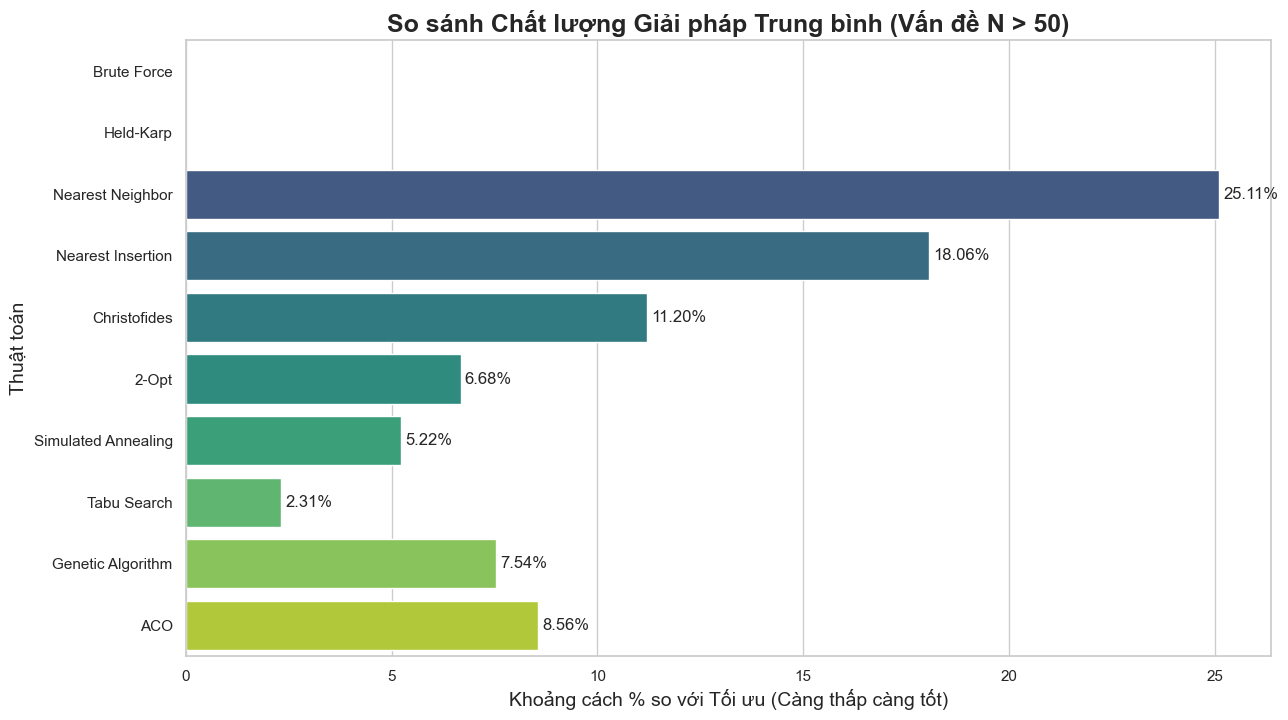

In [9]:
if not df_benchmark.empty:
    # Lấy dữ liệu đã nhóm và sắp xếp
    data_to_plot = df_bench_agg.sort_values(by='gap_percent').reset_index()

    plt.figure(figsize=(14, 8))
    
    # Vẽ biểu đồ cột
    ax = sns.barplot(
        x='gap_percent',
        y='algorithm',
        data=data_to_plot,
        palette='viridis'
    )
    
    ax.set_title('So sánh Chất lượng Giải pháp Trung bình (Vấn đề N > 50)', fontsize=18, fontweight='bold')
    ax.set_xlabel('Khoảng cách % so với Tối ưu (Càng thấp càng tốt)', fontsize=14)
    ax.set_ylabel('Thuật toán', fontsize=14)
    
    # Thêm nhãn giá trị
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.1, # Vị trí x (bên phải cột)
                p.get_y() + p.get_height() / 2, # Vị trí y (ở giữa cột)
                f'{width:.2f}%', # Văn bản
                va='center')
    
    # Lưu biểu đồ
    save_path = os.path.join(IMAGES_DIR, '01_gap_percent_comparison.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Đã lưu biểu đồ vào: {save_path}")
    
    plt.show()
else:
    print("Không có dữ liệu benchmark để vẽ biểu đồ Gap.")

## 5. Trực quan hóa: Thời gian Chạy (Log Scale)

Bây giờ, hãy so sánh thời gian chạy. Vì thời gian chạy có thể chênh lệch rất lớn (từ mili giây đến phút), chúng ta **phải** sử dụng thang đo Logarit (Log Scale) trên trục X.

C:\Users\Bush\AppData\Local\Temp\ipykernel_16244\3716020739.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax_time = sns.barplot(


Đã lưu biểu đồ vào: ../results/charts\02_time_comparison_logscale.png


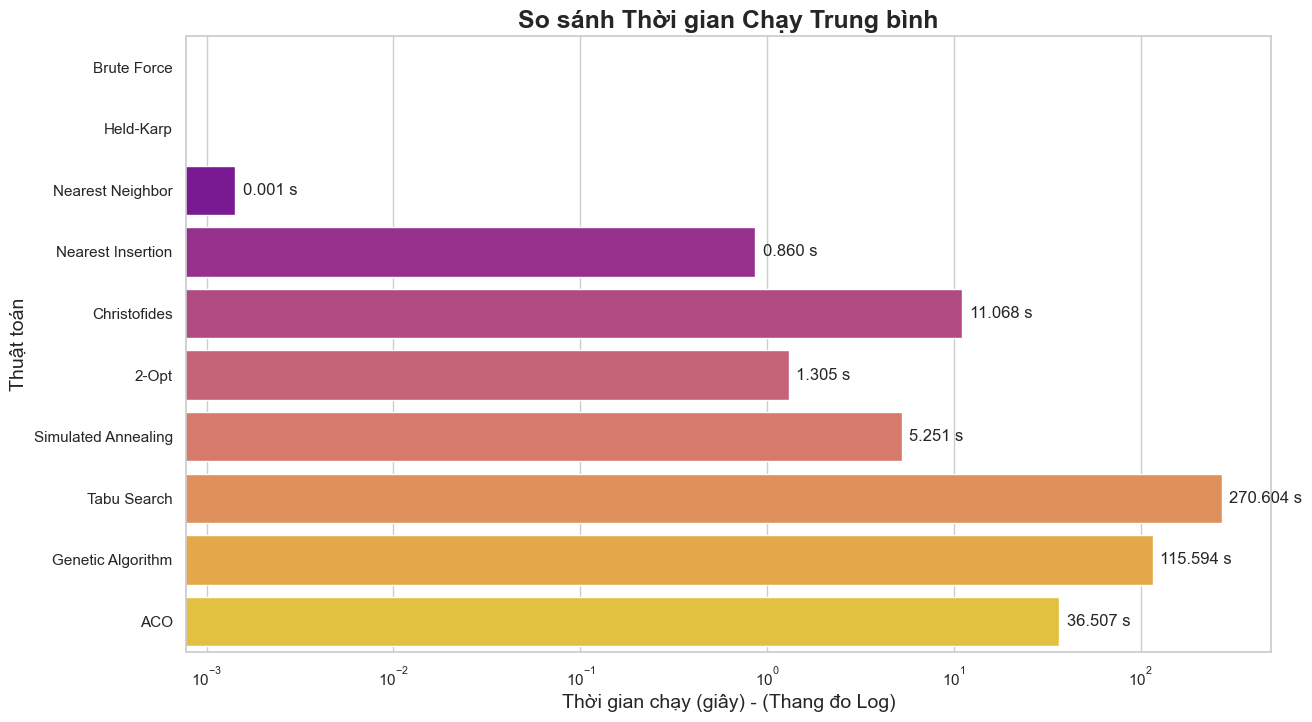

In [10]:
if not df_benchmark.empty:
    # --- Sửa lỗi: Thay thế 'time' bằng 'time_sec' ---
    data_to_plot_time = df_bench_agg.sort_values(by='time_sec').reset_index()
    # -----------------------------------------------------

    plt.figure(figsize=(14, 8))
    
    # Vẽ biểu đồ cột
    ax_time = sns.barplot(
        # --- Sửa lỗi: Thay thế 'time' bằng 'time_sec' ---
        x='time_sec',
        y='algorithm',
        data=data_to_plot_time,
        palette='plasma'
    )
    # -----------------------------------------------------
    
    # !!! ĐẶT TRỤC X SANG THANG ĐO LOG !!!
    ax_time.set_xscale('log')
    
    ax_time.set_title('So sánh Thời gian Chạy Trung bình', fontsize=18, fontweight='bold')
    ax_time.set_xlabel('Thời gian chạy (giây) - (Thang đo Log)', fontsize=14)
    ax_time.set_ylabel('Thuật toán', fontsize=14)
    
    # Thêm nhãn giá trị
    for p in ax_time.patches:
        width = p.get_width()
        ax_time.text(width * 1.1, # Vị trí x (hơi bên phải cột)
                     p.get_y() + p.get_height() / 2,
                     f'{width:.3f} s', # Văn bản
                     va='center')
    
    # Lưu biểu đồ
    save_path = os.path.join(IMAGES_DIR, '02_time_comparison_logscale.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Đã lưu biểu đồ vào: {save_path}")
    
    plt.show()
else:
    print("Không có dữ liệu benchmark để vẽ biểu đồ Thời gian.")

## 6. Trực quan hóa: Tương quan Chất lượng vs Thời gian

Một biểu đồ bong bóng (scatterplot) là cách tốt nhất để xem sự đánh đổi (trade-off) giữa Chất lượng (Gap %) và Thời gian (Time).

* **Trục X:** Thời gian (Log)
* **Trục Y:** Chất lượng (Gap %)
* **Mục tiêu:** Góc dưới cùng bên trái (Nhanh & Tốt)

Đã lưu biểu đồ vào: ../results/charts\03_tradeoff_scatterplot.png


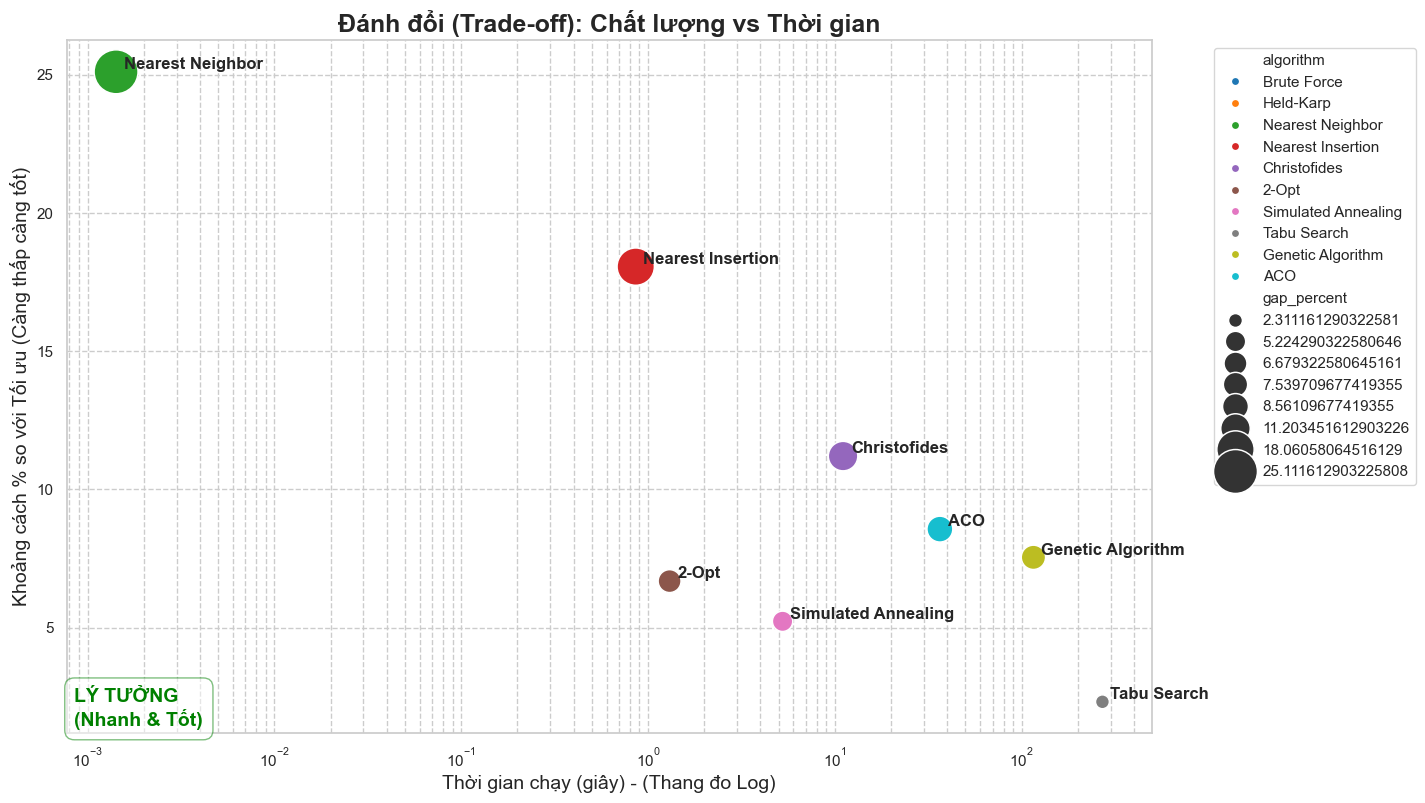

In [11]:
if not df_benchmark.empty:
    # df_bench_agg là kết quả groupby, chứa 'gap_percent' và 'time_sec'
    data_to_plot_tradeoff = df_bench_agg.reset_index()

    plt.figure(figsize=(14, 9))
    
    # Vẽ biểu đồ scatterplot với kích thước bong bóng
    ax_tradeoff = sns.scatterplot(
        # --- Sửa lỗi 1: x='time' -> 'time_sec' ---
        x='time_sec', 
        y='gap_percent',
        hue='algorithm', 
        size='gap_percent', 
        sizes=(100, 1000), 
        legend='full',
        data=data_to_plot_tradeoff,
        palette='tab10'
    )
    
    # Đặt trục X sang thang đo Log
    ax_tradeoff.set_xscale('log')
    
    ax_tradeoff.set_title('Đánh đổi (Trade-off): Chất lượng vs Thời gian', fontsize=18, fontweight='bold')
    ax_tradeoff.set_xlabel('Thời gian chạy (giây) - (Thang đo Log)', fontsize=14)
    ax_tradeoff.set_ylabel('Khoảng cách % so với Tối ưu (Càng thấp càng tốt)', fontsize=14)
    
    # Thêm nhãn cho từng điểm
    for i, row in data_to_plot_tradeoff.iterrows():
        # --- Sửa lỗi 2: row['time'] -> row['time_sec'] ---
        plt.text(row['time_sec'] * 1.1, 
                 row['gap_percent'] + 0.1, 
                 row['algorithm'], 
                 fontweight='semibold')
    
    # Di chuyển chú giải (legend) ra ngoài
    ax_tradeoff.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.grid(True, which="both", ls="--")
    
    # Đánh dấu vùng "Lý tưởng"
    xmin, xmax = ax_tradeoff.get_xlim()
    ymin, ymax = ax_tradeoff.get_ylim()
    ax_tradeoff.text(xmin * 1.1, ymin * 1.1, "LÝ TƯỞNG\n(Nhanh & Tốt)", 
                      color='green', fontsize=14, fontweight='bold', 
                      ha='left', va='bottom',
                      bbox=dict(facecolor='white', alpha=0.5, edgecolor='green', boxstyle='round,pad=0.5'))
    
    # Lưu biểu đồ
    save_path = os.path.join(IMAGES_DIR, '03_tradeoff_scatterplot.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Đã lưu biểu đồ vào: {save_path}")
    
    plt.show()
else:
    print("Không có dữ liệu benchmark để vẽ biểu đồ Tương quan.")